In [1]:
import pandas as pd
import numpy as np
import os
import time
from collections import defaultdict
from sklearn import linear_model
from sklearn.metrics import accuracy_score,f1_score,recall_score,roc_curve
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

Flat Domain adaptation, one dataset is held out, the model is trained on the remaining four datasets. Prediction is done using the parameters of the dataset that is closest to the held out one.

In [2]:
TRAIN_DIRECTORY = "../.././Data/Only_Symptoms/Total/"
TEST_DIRECTORY = "../.././Data/Only_Symptoms/Total/"
coefficients = defaultdict()

In [3]:
def read_file(filename):
    return pd.read_csv(filename)

In [4]:
def get_training_data(files_):
    data = defaultdict()
    columns = defaultdict()
    for i in files_:
        name = i
        name = name.replace('.csv','')
        data[name] = read_file(TRAIN_DIRECTORY+i)
        columns[name] = list(data[name].columns)
        columns[name].remove('virus')
    return data,columns

In [5]:
def overlap_columns(columns_):
    all_columns = list(columns_.values())
    overlap = list(set(all_columns[0]) & set(all_columns[1]) & set(all_columns[2]) & set(all_columns[3]))
    return overlap
    

In [6]:
def create_columns(columns_):
    overlap = overlap_columns(columns_)
    new_columns = []
    temp = []
    for i in columns_.keys():
        x = [i.replace('.csv','')+'_'+j for j in columns_[i]]
        temp.append(x)
    t = [val for sublist in temp for val in sublist]
    new_columns = t + overlap
    new_columns.append('virus')
    return new_columns

In [7]:
def create_new_dataframe(data,columns):
    new_columns = create_columns(columns)
    new_dataset = defaultdict()
    for i,name in enumerate(data.keys()):
        new_data = pd.DataFrame(columns=new_columns)
        dataset = data[name]
        for j in columns[name]:
            new_data[name+'_'+j] = dataset[j]
            new_data[j] = dataset[j]
        new_data['virus'] = dataset['virus']
        new_data.fillna(0,inplace=True)
        new_dataset[name] = new_data
    #concatenate all the dataframe
    new_dataset = pd.concat(new_dataset.values())
    return new_dataset

In [8]:
def ml_model(dataset):
    lm = linear_model.LogisticRegression()
    x_train = dataset.drop(['virus'],axis = 1)
    y_train = dataset['virus']
    x = lm.fit(x_train,y_train)
    coeff = x.coef_.tolist()[0]
    return lm,coeff

#### Heldout dataset : NYUMC

In [9]:
files_nyumc = ['goviral.csv','fluwatch.csv','hongkong.csv','hutterite.csv']
data_nyumc,columns_nyumc = get_training_data(files_nyumc)

#create the dataframe for domain adaptation
new_dataset_nyumc = create_new_dataframe(data_nyumc,columns_nyumc)

coeff_without_nyumc = ml_model(new_dataset_nyumc)
coefficients['nyumc'] = coeff_without_nyumc

#### Heldout dataset : Goviral

In [10]:
files_goviral = ['nyumc.csv','fluwatch.csv','hongkong.csv','hutterite.csv']
data_goviral,columns_goviral = get_training_data(files_goviral)
new_dataset_goviral = create_new_dataframe(data_goviral,columns_goviral)

coeff_without_goviral = ml_model(new_dataset_goviral)
coefficients['goviral'] = coeff_without_goviral

#### Heldout dataset : FluWatch

In [11]:
files_fluwatch = ['nyumc.csv','goviral.csv','hongkong.csv','hutterite.csv']
data_fluwatch,columns_fluwatch = get_training_data(files_fluwatch)
new_dataset_fluwatch = create_new_dataframe(data_fluwatch,columns_fluwatch)

coeff_without_fluwatch = ml_model(new_dataset_fluwatch)
coefficients['fluwatch'] = coeff_without_fluwatch

#### Heldout dataset : HongKong

In [12]:
files_hongkong = ['nyumc.csv','goviral.csv','fluwatch.csv','hutterite.csv']
data_hongkong,columns_hongkong = get_training_data(files_hongkong)
new_dataset_hongkong = create_new_dataframe(data_hongkong,columns_hongkong)

coeff_without_hongkong = ml_model(new_dataset_hongkong)
coefficients['hongkong'] = coeff_without_hongkong

#### Heldout dataset : Hutterite

In [13]:
files_hutterite = ['nyumc.csv','goviral.csv','fluwatch.csv','hongkong.csv']
data_hutterite,columns_hutterite = get_training_data(files_hutterite)
new_dataset_hutterite = create_new_dataframe(data_hutterite,columns_hutterite)

coeff_without_hutterite = ml_model(new_dataset_hutterite)
coefficients['hutterite'] = coeff_without_hutterite

In [14]:
# remove the target variable
def remove_target(data_dict):
    for i in data_dict.keys():
        data_dict[i].drop(['virus'],axis = 1,inplace = True)
    return data_dict

In [15]:
#get the entire training data
files_ = ['nyumc.csv','goviral.csv','fluwatch.csv','hongkong.csv','hutterite.csv']
data_,columns_ = get_training_data(files_)
print(data_.keys())
data_ = remove_target(data_)

dict_keys(['nyumc', 'goviral', 'fluwatch', 'hongkong', 'hutterite'])


#### Get the statistical measure of the dataset:

In [16]:
def get_statistical_measure(data_dict):
    data_stats = defaultdict()
    for i in data_dict.keys():
        data_stats[i] = data_dict[i].var(axis = 0)
    return data_stats

In [17]:
data_stats = get_statistical_measure(data_)

In [18]:
#l2 distance
def get_distance(data_stats):

    distance = defaultdict()
    names = list(data_stats)
    for i in names:
        compare_to = [j for j in names if j!=i]
        distance[i] = [(j,np.linalg.norm((np.asarray(data_stats[i]) - np.asarray(data_stats[j])),ord = 2)) for j in compare_to]
    return distance


In [19]:
distance = get_distance(data_stats)


#### Model for testing the performance

In [20]:
def test_model(train_data,test_data):
    lm,coeff = ml_model(train_data)
    train = test_data.drop(['virus'],axis = 1)
    test = test_data['virus']
    y_pred = lm.predict(train)
    acc = accuracy_score(test,y_pred)
    fpr,tpr,threshold = roc_curve(test,y_pred)
    auc_score = metrics.auc(fpr,tpr)
    return acc,auc_score
    

#### Prepare data for testing

In [21]:
data_,columns = get_training_data(files_)

In [22]:
def create_data_for_testing(data,name,columns_):
    new_data = pd.DataFrame(columns = columns_)
    columns_for_data = list(data.columns)
    col = [x for x in columns_for_data if x != 'virus']
    for i in col:
        new_data[name+'_'+i] = data[i]
        new_data[i] = data[i]
    new_data['virus'] = data['virus']
    new_data.fillna(0,inplace = True)
    return new_data

In [23]:
def test_against_all(dataset_name,to_be_tested_names,data_,original_data,store_):
    columns = list(original_data.columns)
    data = data_[dataset_name]
    for i in to_be_tested_names:
        temp_data = create_data_for_testing(data,i,columns)
        acc,auc_score = test_model(original_data,temp_data)
        print("Comparing against ",i)
        print("Accuracy : ",acc)
        print("Auc Score : ",auc_score)
        print("____________________________")
        store_[i] = auc_score
    return store_

#### Test NYUMC

In [24]:
store_nyumc = defaultdict()
print("Testing NYUMC Data!\n")
store_nyumc = test_against_all('nyumc',['goviral','fluwatch','hongkong','hutterite'],data_,new_dataset_nyumc,store_nyumc)

Testing NYUMC Data!

Comparing against  goviral
Accuracy :  0.697265714155
Auc Score :  0.389257366288
____________________________
Comparing against  fluwatch
Accuracy :  0.144109188844
Auc Score :  0.0855787863751
____________________________
Comparing against  hongkong
Accuracy :  0.424978317433
Auc Score :  0.615690147314
____________________________
Comparing against  hutterite
Accuracy :  0.215547541882
Auc Score :  0.484616733064
____________________________


In [25]:
store_nyumc

defaultdict(None,
            {'fluwatch': 0.085578786375050966,
             'goviral': 0.38925736628756213,
             'hongkong': 0.61569014731429383,
             'hutterite': 0.48461673306448311})

#### Test Goviral

In [26]:
store_gv = defaultdict()
print("Testing Goviral data!\n")
store_gv = test_against_all('goviral',['nyumc','fluwatch','hongkong','hutterite'],data_,new_dataset_goviral,store_gv)

Testing Goviral data!

Comparing against  nyumc
Accuracy :  0.476923076923
Auc Score :  0.519155449512
____________________________
Comparing against  fluwatch
Accuracy :  0.513461538462
Auc Score :  0.557849007338
____________________________
Comparing against  hongkong
Accuracy :  0.686538461538
Auc Score :  0.684576599289
____________________________
Comparing against  hutterite
Accuracy :  0.748076923077
Auc Score :  0.745606926875
____________________________


In [27]:
store_gv

defaultdict(None,
            {'fluwatch': 0.55784900733804532,
             'hongkong': 0.68457659928870485,
             'hutterite': 0.74560692687465302,
             'nyumc': 0.51915544951154735})

#### Test Fluwatch

In [28]:
store_fw = defaultdict()
print("Testing FluWatch data!\n")
store_fw = test_against_all('fluwatch',['nyumc','goviral','hongkong','hutterite'],data_,new_dataset_fluwatch,store_fw)

Testing FluWatch data!

Comparing against  nyumc
Accuracy :  0.512568306011
Auc Score :  0.525679620507
____________________________
Comparing against  goviral
Accuracy :  0.548633879781
Auc Score :  0.540351517363
____________________________
Comparing against  hongkong
Accuracy :  0.498360655738
Auc Score :  0.451506720185
____________________________
Comparing against  hutterite
Accuracy :  0.618579234973
Auc Score :  0.610662591984
____________________________


In [29]:
store_fw

defaultdict(None,
            {'goviral': 0.54035151736301168,
             'hongkong': 0.45150672018488114,
             'hutterite': 0.61066259198443107,
             'nyumc': 0.52567962050720674})

#### Test Hongkong

In [30]:
store_hk = defaultdict()
print("Testing Hongkong!\n")
store_hk = test_against_all('hongkong',['nyumc','goviral','fluwatch','hutterite'],data_,new_dataset_hongkong,store_hk)

Testing Hongkong!

Comparing against  nyumc
Accuracy :  0.764432781591
Auc Score :  0.664985099033
____________________________
Comparing against  goviral
Accuracy :  0.84658861526
Auc Score :  0.781138766072
____________________________
Comparing against  fluwatch
Accuracy :  0.748687928946
Auc Score :  0.65692946199
____________________________
Comparing against  hutterite
Accuracy :  0.810052482842
Auc Score :  0.769685349429
____________________________


In [31]:
store_hk

defaultdict(None,
            {'fluwatch': 0.6569294619900915,
             'goviral': 0.78113876607228694,
             'hutterite': 0.76968534942860267,
             'nyumc': 0.66498509903302294})

#### Test hutterite

In [32]:
store_ht = defaultdict()
print("Testing hutterite!\n")
store_ht = test_against_all('hutterite',['nyumc','goviral','fluwatch','hongkong'],data_,new_dataset_hutterite,store_ht)

Testing hutterite!

Comparing against  nyumc
Accuracy :  0.478532396565
Auc Score :  0.553747897258
____________________________
Comparing against  goviral
Accuracy :  0.644808743169
Auc Score :  0.664578499812
____________________________
Comparing against  fluwatch
Accuracy :  0.630757220921
Auc Score :  0.681027475835
____________________________
Comparing against  hongkong
Accuracy :  0.669008587041
Auc Score :  0.634156253697
____________________________


In [33]:
store_ht

defaultdict(None,
            {'fluwatch': 0.68102747583453793,
             'goviral': 0.66457849981223227,
             'hongkong': 0.63415625369748285,
             'nyumc': 0.55374789725756091})

In [34]:
results = defaultdict()
results['nyumc'] = store_nyumc
results['goviral'] = store_gv
results['fluwatch'] = store_fw
results['hongkong'] = store_hk
results['hutterite'] = store_ht
results

defaultdict(None,
            {'fluwatch': defaultdict(None,
                         {'goviral': 0.54035151736301168,
                          'hongkong': 0.45150672018488114,
                          'hutterite': 0.61066259198443107,
                          'nyumc': 0.52567962050720674}),
             'goviral': defaultdict(None,
                         {'fluwatch': 0.55784900733804532,
                          'hongkong': 0.68457659928870485,
                          'hutterite': 0.74560692687465302,
                          'nyumc': 0.51915544951154735}),
             'hongkong': defaultdict(None,
                         {'fluwatch': 0.6569294619900915,
                          'goviral': 0.78113876607228694,
                          'hutterite': 0.76968534942860267,
                          'nyumc': 0.66498509903302294}),
             'hutterite': defaultdict(None,
                         {'fluwatch': 0.68102747583453793,
                          'goviral': 0.6645784

In [35]:
for k,v in distance.items():
    print(k)
    print(min(v, key = lambda t:t[1]))
    print("____________")

nyumc
('hongkong', 0.46794596727436427)
____________
goviral
('hutterite', 1.0853978426482258)
____________
fluwatch
('hutterite', 0.81244322244654488)
____________
hongkong
('nyumc', 0.46794596727436427)
____________
hutterite
('hongkong', 0.56378519256897985)
____________


#### Considering only the symptoms where the target is positive

In [36]:
data_,columns = get_training_data(files_)

In [37]:
def only_positive_data_stats(data_dict):
    data_stats = defaultdict()
    for i in data_dict.keys():
        data = data_dict[i]
        data = data.loc[data['virus'] == 1]
        data_stats[i] = data.var(axis = 0)
    return data_stats

In [38]:
positive_data_stats = only_positive_data_stats(data_)

In [39]:
positive_distance = get_distance(positive_data_stats)

#### compare the variance when only the positive target is considered whereas the total

In [45]:
def create_plots(columns,dict_,name,order,label,title):
    df = pd.DataFrame(columns)
    df_list = []
    for i in dict_.keys():
        df_list.append(pd.DataFrame({k:[v] for (k,v) in dict(dict_[i]).items()}))
    df = pd.concat(df_list)
#     df.fillna(0,inplace = True)
    df[name] = columns
    df.set_index(name,inplace = True)
    df = df[order]
    sns.set()
    ax = plt.axes()
    sns.heatmap(df,annot=True,linewidth = 0.8,ax = ax,cbar_kws = {'label' : label},fmt='f')
    ax.set_title(title)
    ax.set_xlabel('Dataset')
    plt.show()
    return df
    

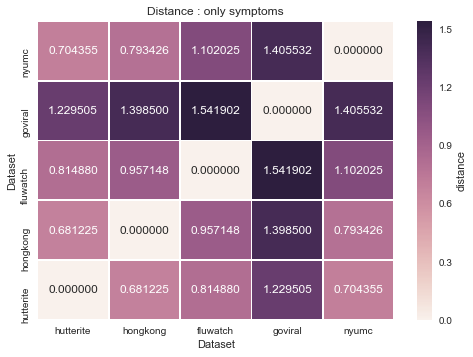

In [41]:
positive_distances = create_plots(['nyumc','goviral','fluwatch','hongkong','hutterite'],
                  positive_distance,
                  'Dataset',
                  ['hutterite','hongkong','fluwatch','goviral','nyumc'],'distance',
                  'Distance : only symptoms')

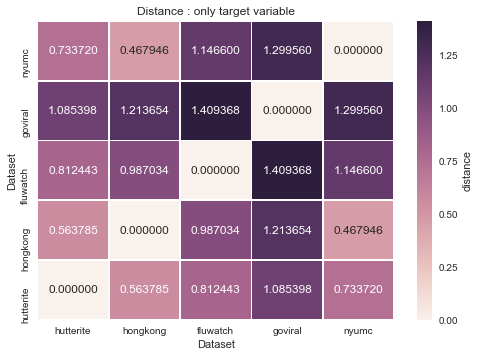

In [42]:
general_distance = create_plots(['nyumc','goviral','fluwatch','hongkong','hutterite'],
                  distance,
                  'Dataset',
                  ['hutterite','hongkong','fluwatch','goviral','nyumc'],'distance',
                  'Distance : only target variable')

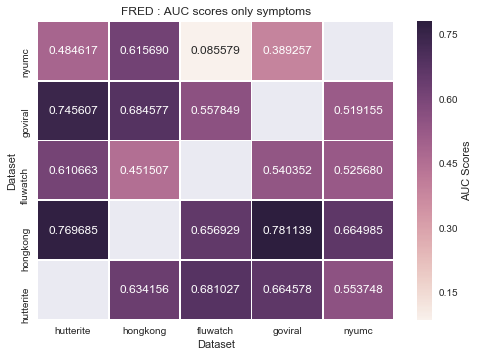

In [46]:
nyumc = create_plots(['nyumc','goviral','fluwatch','hongkong','hutterite'], 
                     results, 
                     'Dataset',
                     ['hutterite','hongkong','fluwatch','goviral','nyumc'],'AUC Scores','FRED : AUC scores only symptoms')

In [44]:
results

defaultdict(None,
            {'fluwatch': defaultdict(None,
                         {'goviral': 0.54035151736301168,
                          'hongkong': 0.45150672018488114,
                          'hutterite': 0.61066259198443107,
                          'nyumc': 0.52567962050720674}),
             'goviral': defaultdict(None,
                         {'fluwatch': 0.55784900733804532,
                          'hongkong': 0.68457659928870485,
                          'hutterite': 0.74560692687465302,
                          'nyumc': 0.51915544951154735}),
             'hongkong': defaultdict(None,
                         {'fluwatch': 0.6569294619900915,
                          'goviral': 0.78113876607228694,
                          'hutterite': 0.76968534942860267,
                          'nyumc': 0.66498509903302294}),
             'hutterite': defaultdict(None,
                         {'fluwatch': 0.68102747583453793,
                          'goviral': 0.6645784